### Load the important libraries

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from thefuzz import fuzz, process
import swifter
sns.set()

### We start with loading data from merged_data from interim data from the last step

In [186]:
#Import data saved from the last saved data
merged_data = pd.read_csv("../data/interim/merged_data.csv")

In [187]:
merged_data.head(5)

,Title,description,authors,categories,User_id,review/score,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,Julie Strain,"['Comics', 'Graphic Novels']",AVCGYZL8FQQTD,4.0,nice collection of julie strain images,this is only for julie strain fans its a colle...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A3UH4UZ4RSVO82,5.0,essential for every personal and public library,if people become the books they read and if th...
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A22X4XUPKF66MR,4.0,good academic overview,philip nel dr seuss american iconthis is basi...


### We will prepare the dataset for collaborative filtering. We should have rows for users, columns as the movie names and values as the ratings that the user has provided 

In [211]:
merged_data.isna().sum()

Title                  0
description       204181
authors            42665
categories             0
User_id           460235
review/score           0
review/summary      1698
review/text           12
dtype: int64

### Since for collaborative filtering a review with a valid user is important, we will remove all the rows with user_id as null

In [256]:
merged_data_valid_user_id = merged_data[~merged_data['User_id'].isna()]

### Now we need to filterout reviews from users who have given too few reviews. We will use the cut-off of 10, assuming users who have given less than 10 reviews don't provide sufficient information for providing a recommendation

### As a first step, we will group-by by users to get the right statistics

In [257]:
merged_data_user_id_group_all = merged_data_valid_user_id.groupby('User_id').agg('count').sort_values(by='Title', ascending=False)

### Only select users who have given more than 10 ratings

In [266]:
merged_data_user_id_group_gt10 = merged_data_user_id_group_all[merged_data_user_id_group_all.Title >= 10]

In [320]:
merged_data_user_id_group_gt10.head(10)

,Title,description,authors,categories,review/score,review/summary,review/text
User_id,,,,,,,
A14OJS0VWMOSWO,4819,4431,4733,4819,4819,4819,4819
AFVQZQ8PW0L,3049,2907,3018,3049,3049,3049,3049
A1D2C0WDCSHUWZ,2360,2230,2352,2360,2360,2360,2360
AHD101501WCN1,1549,1265,1518,1549,1549,1549,1549
A1X8VZWTOG8IS6,1391,1249,1358,1391,1391,1391,1391
A1K1JW1C5CUSUZ,1117,1049,1098,1117,1117,1117,1117
A20EEWWSFMZ1PN,1067,954,1051,1067,1067,1067,1067
A1S3C5OFU508P3,1002,808,971,1002,1002,1002,1002
A2OJW07GQRNJUT,805,563,789,805,805,805,805


### Let's explore the data further

In [269]:
merged_data_user_id_group_gt10.describe()

,Title,description,authors,categories,review/score,review/summary,review/text
count,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000,21178.000000
mean,27.315186,25.084758,26.906696,27.315186,27.315186,27.293134,27.315186
std,61.682249,56.392874,60.658086,61.682249,61.682249,61.683619,61.682249
min,10.000000,0.000000,0.000000,10.000000,10.000000,0.000000,10.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,15.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000
75%,24.000000,22.000000,24.000000,24.000000,24.000000,24.000000,24.000000
max,4819.000000,4431.000000,4733.000000,4819.000000,4819.000000,4819.000000,4819.000000


C:\Users\dikshashukla\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


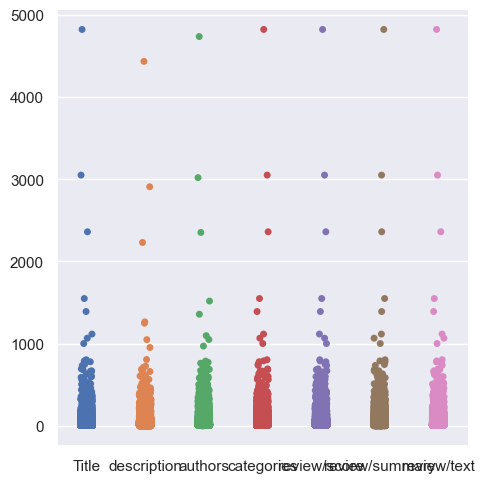

In [321]:
sns.catplot(merged_data_user_id_group_gt10)

### We see there are clear outliers as a few users have given too many ratings. These users are outliers and they may skew the recommendations. Based on the graph above, we will use a cutoff of 1300 reviews, meaning we will leave the users who have given more than 1300 reviews

In [278]:
merged_data_user_id_cut_off = merged_data_user_id_group_gt10[merged_data_user_id_group_gt10.Title < 800]

In [279]:
merged_data_user_id_cut_off.describe()

,Title,description,authors,categories,review/score,review/summary,review/text
count,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000,21169.000000
mean,26.516227,24.365298,26.120365,26.516227,26.516227,26.494166,26.516227
std,40.678795,36.954065,39.925259,40.678795,40.678795,40.680440,40.678795
min,10.000000,0.000000,0.000000,10.000000,10.000000,0.000000,10.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,15.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000
75%,24.000000,22.000000,24.000000,24.000000,24.000000,24.000000,24.000000
max,791.000000,727.000000,774.000000,791.000000,791.000000,791.000000,791.000000


C:\Users\dikshashukla\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


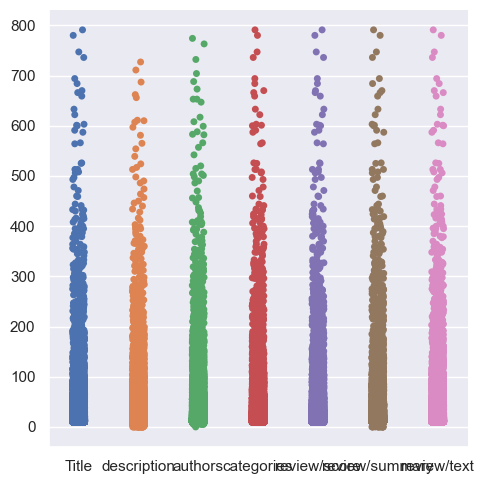

In [323]:
sns.catplot(merged_data_user_id_cut_off,)

### Clearly, we don't have outliers in terms of # reviews written

### Let's keep only relevant rows in the main dataset. That is we will only keep the rows corresponding to the users in the merged_data_user_id_cut_off dataset

In [284]:
merged_data_valid_user_id = merged_data_valid_user_id[merged_data_valid_user_id.User_id.isin(merged_data_user_id_cut_off.index)]

In [286]:
merged_data_valid_user_id.shape

(561322, 8)

In [287]:
merged_data_valid_user_id.head(5)

,Title,description,authors,categories,User_id,review/score,review/summary,review/text
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...
5,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2F6NONFUDB6UK,4.0,one of americas greatest creative talents,dr seuss american icon by philip nel is a thou...
11,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,['Religion'],A373VVEU6Z9M0N,5.0,small churches can have wonderful worship,many small churches feel like they can not hav...
54,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,['Social Science'],A3NIQK6ZLYEP1L,4.0,almost a day by day view,steven wardell went to japan without reading a...


### For collaborative filtering, we just need - Title, User_id and review/score

In [289]:
rating_user_cf = merged_data_valid_user_id[["Title", "User_id", "review/score"]]

In [290]:
rating_user_cf.head(5)

,Title,User_id,review/score
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0
5,Dr. Seuss: American Icon,A2F6NONFUDB6UK,4.0
11,Wonderful Worship in Smaller Churches,A373VVEU6Z9M0N,5.0
54,Rising Sons and Daughters: Life Among Japan's ...,A3NIQK6ZLYEP1L,4.0


### We have strings in our dataset for Title and User_id but we will convert them into int. We will create a new dataframe with these columns - userid, bookid, rating.

### We will use pd.factorize for creating integer values for strings

In [313]:
user_book_reviews_ids = pd.DataFrame({'User_Id': pd.factorize(rating_user_cf.User_id)[0], "Book_Id":pd.factorize(rating_user_cf.Title)[0], "Ratings": rating_user_cf['review/score']}).reset_index(drop=True)

In [314]:
user_book_reviews_ids.head(5)

,User_Id,Book_Id,Ratings
0,0,0,5.0
1,1,0,4.0
2,2,0,4.0
3,3,1,5.0
4,4,2,4.0


### Now we split the data in train and test

In [317]:
from sklearn.model_selection import train_test_split
X = user_book_reviews_ids[['User_Id', 'Book_Id']]
y = user_book_reviews_ids['Ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 0)

In [318]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(420991, 2) (140331, 2) (420991,) (140331,)


### We have our train and test data sets ready. In the next stage, we will build collaborative filtering model using PyTorch